In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
sys.path.append("../tools/")
sys.path.append("../impl/")

import matplotlib.pyplot as plt
#import seaborn as sns

% matplotlib inline

In [2]:
from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data, test_classifier
from preprocess import preprocess_df, preprocess, clean, ordered_columns

Get and clean data

In [4]:
with open("../impl/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient="index")
fixed_df = clean(df)
original_features = fixed_df.columns
fixed_df = preprocess_df(df)

my_dataset = preprocess(data_dict)

In [5]:
fixed_df.shape

(143, 36)

Oridinal features

In [6]:
print "Original number of features (columns) ", fixed_df[original_features].shape[1]
print "******************"
fixed_df[original_features].info()

Original number of features (columns)  20
******************
<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       94 non-null float64
to_messages                  86 non-null float64
deferral_payments            38 non-null float64
total_payments               123 non-null float64
exercised_stock_options      101 non-null float64
bonus                        81 non-null float64
restricted_stock             109 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    17 non-null float64
total_stock_value            125 non-null float64
expenses                     94 non-null float64
from_messages                86 non-null float64
other                        91 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          143 non-null bool
director_fees                16 non-null float64
deferred_income              48 n

Here we will introduce a few new features which possibly are more informative for analysis:

First we will scale number of emails from and to POI to the overall number of received and sent emails by a person.
We will add new feature - gross payments which also include deferred_income. Using this new feature we will calculate percentages for all constitutions of total payments. For example, salary_perc shows what percent in gross total payments goes as salary. In the same way we will calculate percentages of gross stock value constitutions.

In [7]:
new_columns = [col for col in fixed_df.columns if col not in original_features]
print "Added {} new columns".format(len(new_columns))
print "***********************"
fixed_df[new_columns].info()

Added 16 new columns
***********************
<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 16 columns):
from_poi_perc                     86 non-null float64
to_poi_perc                       86 non-null float64
shared_with_poi_perc              86 non-null float64
gross_payments                    46 non-null float64
gross_stock_value                 14 non-null float64
salary_perc                       36 non-null float64
bonus_perc                        33 non-null float64
long_term_incentive_perc          23 non-null float64
deferred_income_perc              46 non-null float64
deferral_payments_perc            16 non-null float64
other_perc                        36 non-null float64
expenses_perc                     37 non-null float64
director_fees_perc                10 non-null float64
exercised_stock_options_perc      11 non-null float64
restricted_stock_perc             13 non-null float64
restricted_stock_deferred

Define set of feature and prepare data in X, y format 

In [8]:
features_list = ['poi'] + ordered_columns + ["to_messages", "from_messages"] + new_columns

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Feature selection

In [9]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler 

Scale features

In [10]:
scaler = MinMaxScaler()
features_scl = scaler.fit_transform(features)

In [11]:
var_selector = VarianceThreshold()
var_selector.fit(features_scl)

VarianceThreshold(threshold=0.0)

Explore variance (for min/max scales features)

In [12]:
sorted(zip(features_list[1:], var_selector.variances_), key = lambda s: s[1] )[:20]

[('restricted_stock_deferred', 0.0057008781329716193),
 ('other', 0.0070020821085249839),
 ('total_payments', 0.0072950662949107393),
 ('gross_payments', 0.007479037062175945),
 ('expenses_perc', 0.0078434398111576261),
 ('restricted_stock_deferred_perc', 0.0079103443140828046),
 ('gross_stock_value', 0.010156257000555391),
 ('from_messages', 0.010189564181207393),
 ('deferral_payments', 0.013330164805773632),
 ('restricted_stock', 0.013466388894725009),
 ('total_stock_value', 0.015828735181540422),
 ('restricted_stock_perc', 0.017412374845339786),
 ('long_term_incentive', 0.017805914835129298),
 ('deferral_payments_perc', 0.018737572542050378),
 ('exercised_stock_options', 0.019466332873964896),
 ('to_messages', 0.021769340545398159),
 ('bonus', 0.023710217608850968),
 ('other_perc', 0.025048413744205744),
 ('from_poi_perc', 0.027998976863101828),
 ('deferred_income', 0.029883043853425072)]

Perform ANOVA F-test

In [13]:
f, pval = f_classif(features, labels)

In [14]:
sorted(zip(features_list[1:], f), key = lambda s: s[1], reverse=True )[:20]

[('exercised_stock_options', 24.815079733218194),
 ('total_stock_value', 24.182898678566879),
 ('bonus', 20.792252047181535),
 ('bonus_perc', 19.709040157047042),
 ('salary', 18.289684043404513),
 ('to_poi_perc', 16.409712548035792),
 ('long_term_incentive_perc', 12.103787195478331),
 ('deferred_income', 11.458476579280369),
 ('gross_payments', 11.334277294828178),
 ('long_term_incentive', 9.9221860131898225),
 ('restricted_stock', 9.2128106219771002),
 ('shared_with_poi_perc', 9.1012687391935039),
 ('total_payments', 8.7727777300916756),
 ('other', 7.1501974379898821),
 ('expenses', 6.0941733106389453),
 ('other_perc', 4.3578903441334003),
 ('salary_perc', 4.1067803553605771),
 ('from_poi_perc', 3.1280917481567192),
 ('director_fees', 2.1263278020077054),
 ('to_messages', 1.6463411294420076)]

In [15]:
sorted(zip(features_list[1:], pval), key = lambda s: s[1], reverse=False )[:20]

[('exercised_stock_options', 1.8182048777865317e-06),
 ('total_stock_value', 2.4043152760436886e-06),
 ('bonus', 1.10129873239521e-05),
 ('bonus_perc', 1.8064025768441483e-05),
 ('salary', 3.4782737683651706e-05),
 ('to_poi_perc', 8.3889533567042162e-05),
 ('long_term_incentive_perc', 0.00066974163511083833),
 ('deferred_income', 0.00092203670846723062),
 ('gross_payments', 0.00098082726872157416),
 ('long_term_incentive', 0.0019941812453537077),
 ('restricted_stock', 0.002862802957909168),
 ('shared_with_poi_perc', 0.0030312943103536103),
 ('total_payments', 0.0035893261725153044),
 ('other', 0.0083808944609322627),
 ('expenses', 0.014758199965371975),
 ('other_perc', 0.03863720323456063),
 ('salary_perc', 0.044596998183474033),
 ('from_poi_perc', 0.079116105663795441),
 ('director_fees', 0.14701111317392224),
 ('to_messages', 0.20156265029435688)]

Explore mutual information

In [16]:
from sklearn.feature_selection import mutual_info_classif

In [17]:
minf = mutual_info_classif(features, labels)
sorted(zip(features_list[1:], minf), key = lambda s: s[1], reverse=True )[:20]

[('restricted_stock_perc', 0.074886727323729252),
 ('bonus', 0.07298694172712783),
 ('expenses', 0.069549979272630402),
 ('other', 0.067042800255028734),
 ('gross_payments', 0.061039217923051892),
 ('to_poi_perc', 0.053698380228472953),
 ('expenses_perc', 0.052973975086274994),
 ('restricted_stock_deferred', 0.046318149435743416),
 ('restricted_stock', 0.04335041463110656),
 ('total_stock_value', 0.042176284272557263),
 ('other_perc', 0.0394424663538957),
 ('from_poi_perc', 0.039292038802962725),
 ('restricted_stock_deferred_perc', 0.03814230812226671),
 ('director_fees', 0.034282207534269027),
 ('salary', 0.024725139588257505),
 ('shared_with_poi_perc', 0.020304771071133931),
 ('director_fees_perc', 0.018580601026940702),
 ('deferral_payments_perc', 0.016205217669766903),
 ('to_messages', 0.012296363796227228),
 ('gross_stock_value', 0.011377622388014874)]

TO DO: Make summary regarding introduced features

## PCA and Data Visualisation

In [18]:
exclude = ["poi", "email_address"]
all_features_list = [f for f in my_dataset.items()[0][1].keys() if f not in exclude]

features_list_org = ['poi'] + ordered_columns + ["to_messages", "from_messages"]
features_list_ext = features_list_org + ["to_poi_perc", "from_poi_perc", "shared_with_poi_perc"]
features_list_full = ["poi"] + all_features_list

In [19]:
from sklearn.decomposition import PCA

labels, features = targetFeatureSplit(featureFormat(my_dataset, features_list_org, sort_keys = True))
scaler = MinMaxScaler()
features_scl = scaler.fit_transform(features)
pca = PCA()
pca.fit(features_scl)

features_trf = pca.transform(features_scl)

In [20]:
pca.explained_variance_ratio_

array([  3.35310614e-01,   1.56179712e-01,   1.24116826e-01,
         1.02473738e-01,   7.94925675e-02,   4.76877910e-02,
         3.25273727e-02,   2.92559869e-02,   2.61835652e-02,
         2.05307273e-02,   1.78120379e-02,   1.61921381e-02,
         1.22104169e-02,   2.63638137e-05,   1.43632916e-07])

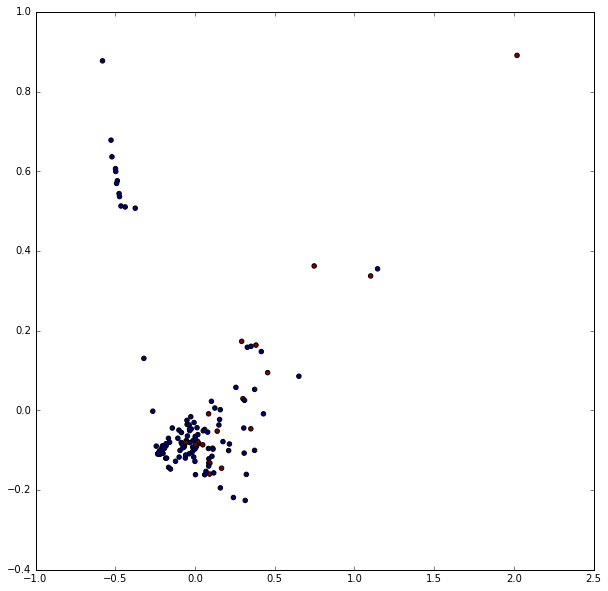

In [21]:
plt.subplots(figsize=(10,10))

plt.scatter(x=features_trf[:,0],y=features_trf[:,1],c=labels)

In [22]:
labels, features = targetFeatureSplit(featureFormat(my_dataset, features_list_ext, sort_keys = True))

features_scl = scaler.fit_transform(features)
pca = PCA()
pca.fit(features_scl)

features_trf = pca.transform(features_scl)

In [23]:
pca.explained_variance_ratio_

array([  3.86396250e-01,   1.55532153e-01,   9.23487510e-02,
         7.65632730e-02,   5.96361741e-02,   4.80108501e-02,
         3.37432266e-02,   2.94255151e-02,   2.78553120e-02,
         1.94116424e-02,   1.71687897e-02,   1.56595726e-02,
         1.15942030e-02,   1.06212060e-02,   8.89147686e-03,
         7.12597894e-03,   1.55428784e-05,   8.25500115e-08])

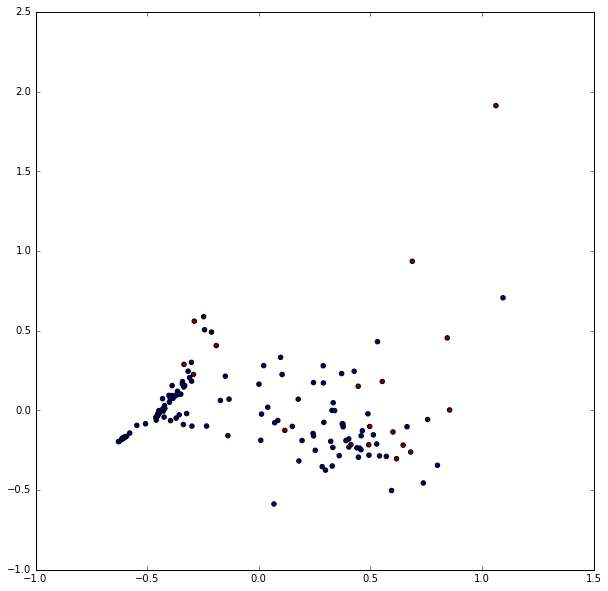

In [24]:
plt.subplots(figsize=(10,10))
plt.scatter(x=features_trf[:,0],y=features_trf[:,1],c=labels)